In [1]:
import numpy as np
import pandas as pd
import os
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
from pydub import AudioSegment
import glob 
import librosa.display
import pickle
import random
import gc
from ignite.handlers import FastaiLRFinder

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
from torch.nn.modules.activation import ReLU

In [3]:
tensor_trx1 = torch.load('../input/train-test-dataset/anchtensor_train.pt')
tensor_trx2 = torch.load('../input/train-test-dataset/positensor_train.pt')
tensor_trxy = torch.load('../input/train-test-dataset/idtensor_train.pt')
tensor_tsx1 = torch.load('../input/train-test-dataset/anchtensor_test.pt')
tensor_tsx2 = torch.load('../input/train-test-dataset/positensor_test.pt')
tensor_tsxy = torch.load('../input/train-test-dataset/idtensor_test.pt')

In [4]:
tensor_trx1.shape

torch.Size([24257, 32000])

In [5]:
batch_size = 32

In [6]:
train_dataset = TensorDataset(tensor_trx1, tensor_trxy, tensor_trx2) 
test_dataset = TensorDataset(tensor_tsx1, tensor_tsxy, tensor_tsx2) 
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # create your dataloader
validation_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, drop_last=True) # create your dataloader

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [8]:
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm1d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.conv3 = nn.Conv1d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm1d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv1d(image_channels, 64, kernel_size=7, stride=2, padding=0)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=0)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.conv5 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.conv6 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn6 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.conv7 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)
        self.bn7 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.conv8 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=0)
        self.bn8 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.conv9 = nn.Conv1d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=0)
        self.bn9 = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
#         self.avgpool = nn.AdaptiveAvgPool1d(4)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(15360, num_classes)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)
        x = self.conv7(x)
        x = self.bn7(x)
        x = self.relu(x)
        x = self.conv8(x)
        x = self.bn8(x)
        x = self.relu(x)
        x = self.conv9(x)
        x = self.bn9(x)
        x = self.relu(x)
#         x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv1d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm1d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=1, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=1, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


def ResNet50(img_channels=1, num_classes=1000):
    return ResNet(50, Block, img_channels, num_classes)


def ResNet101(img_channels=1, num_classes=1000):
    return ResNet(101, Block, img_channels, num_classes)


def ResNet152(img_channels=1, num_classes=1000):
    return ResNet(152, Block, img_channels, num_classes)


model = ResNet18(img_channels=1, num_classes=512).to(device)
print(model)

ResNet(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
      (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    

In [9]:
# a = torch.rand(32,32000).to(device)
# b = model(a.unsqueeze(1))
# b.shape

In [10]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+---------------------------------------+------------+
|                Modules                | Parameters |
+---------------------------------------+------------+
|              conv1.weight             |    448     |
|               conv1.bias              |     64     |
|               bn1.weight              |     64     |
|                bn1.bias               |     64     |
|         layer1.0.conv1.weight         |    4096    |
|          layer1.0.conv1.bias          |     64     |
|          layer1.0.bn1.weight          |     64     |
|           layer1.0.bn1.bias           |     64     |
|         layer1.0.conv2.weight         |   12288    |
|          layer1.0.conv2.bias          |     64     |
|          layer1.0.bn2.weight          |     64     |
|           layer1.0.bn2.bias           |     64     |
|         layer1.0.conv3.weight         |    4096    |
|          layer1.0.conv3.bias          |     64     |
|          layer1.0.bn3.weight          |     64     |
|         

14795072

In [11]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
       
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
     
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [12]:
class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer("negatives_mask", ((~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()).to(device))
            
    def forward(self, emb_i, emb_j, id_array):
        """
        emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
        z_i, z_j as per SimCLR paper
        """
        z_i = F.normalize(emb_i, dim=1)
        z_j = F.normalize(emb_j, dim=1)

        representations = torch.cat([z_i, z_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
#         print(similarity_matrix)
        
        idrepres = torch.cat([id_array,id_array], dim=0)
        idrepres = torch.broadcast_to(idrepres, (batch_size*2,batch_size*2))
#         print(idrepres)
#         print(idrepres.shape)
        idsim_matrix = ((torch.eq(idrepres, idrepres.T)).float()).to(device)
#         print(idsim_matrix)
        idsim_matrix = self.negatives_mask * idsim_matrix
#         print(idsim_matrix)

        cardinality = torch.sum(idsim_matrix, dim=0)
#         print(cardinality)

        numerator = torch.exp((idsim_matrix * similarity_matrix)/ self.temperature)
#         print(numerator)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
#         print(denominator)

        loss_partial = torch.log(torch.div(numerator, torch.sum(denominator, dim=0)))
#         print(loss_partial)
        loss_partial = loss_partial * idsim_matrix
#         print(loss_partial)

        loss_partial = torch.sum(loss_partial, dim=0)
#         print(loss_partial)
        loss_partial = -torch.div(loss_partial, cardinality)
#         print(loss_partial)

        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

In [13]:
loss_fn = ContrastiveLoss(batch_size, 0.07)
loss_fn2 = SupConLoss(temperature=0.07)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=5,verbose=True)

In [14]:
# a = torch.rand([6,512])
# b = torch.rand([6])

In [15]:
# loss = loss_fn(a,a,b)

In [16]:
cost_validation = []
cost_train = []
# similarity_score = []
min_loss = 7.011
p = 0
s1 = []
s2 = []
s3 = []
s4 = []

In [17]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    accum_iter = 64
    loss_train = 0.0
    model.train()
    for batch, (X, y, z) in enumerate(dataloader):
        X, y, z = X.to(device), y.to(device), z.to(device)
        # Compute prediction error
        with torch.set_grad_enabled(True):
            
            pred_anch = model(X.unsqueeze(1))
            pred_posi = model(z.unsqueeze(1))
#             loss1 = loss_fn(pred_anch, pred_posi, y)
            z_i = F.normalize(pred_anch , dim=1)
            z_j = F.normalize(pred_posi, dim=1)
            projX = z_i.view(z_i.shape[0],1,z_i.shape[1])
            projY = z_j.view(z_j.shape[0],1,z_j.shape[1])
            features = torch.cat([projX, projY], dim=1)
            loss = loss_fn2(features, y)
#             print(loss1, 'prathamesh')
#             print(loss, 'official')
            loss_train += loss.item()
            loss = loss / accum_iter
            # Backpropagation
            
            loss.backward()
            
            if ((batch + 1) % accum_iter == 0) or (batch + 1 == len(dataloader)):
                optimizer.step()
                optimizer.zero_grad()
        
    loss_train /= num_batches
#     print(num_batches)
    print(f"loss_avg_all_batches: {loss_train}")
    return loss_train 

In [18]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss= 0.0
    with torch.no_grad():
        for batch, (X, y, z) in enumerate(dataloader):
            X, y, z = X.to(device), y.to(device), z.to(device)
            pred_anch = model(X.unsqueeze(1))
            pred_posi = model(z.unsqueeze(1))
            test_loss += loss_fn(pred_anch, pred_posi, y).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
#     correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} ")
#     print(num_batches)
    return test_loss

In [19]:
def checker(model):
    model.eval()
    with torch.no_grad():
        
        
        v1, sr1 = librosa.load('../input/two-dif-voice-and-sentences/Aditya_voice_1.ogg', sr=16000, offset=0.9, duration=2.0)
        v2, sr2 = librosa.load('../input/two-dif-voice-and-sentences/Aditya_voice_2.ogg', sr=16000, offset=0.3, duration=2.0)
        
        d1, srd1 = librosa.load('../input/two-dif-voice-and-sentences/Dikshi_voice_1.ogg', sr=16000, offset=0.3, duration=2.0)
        d2, srd2 = librosa.load('../input/two-dif-voice-and-sentences/Dikshit_voice_2.ogg', sr=16000, offset=0.7, duration=2.0)
    
        v1 = torch.tensor(v1).to(device)
        v2 = torch.tensor(v2).to(device)
        
        d1 = torch.tensor(d1).to(device)
        d2 = torch.tensor(d2).to(device)
        
        v1 = v1.unsqueeze(0)
        v2 = v2.unsqueeze(0)
        
        d1 = d1.unsqueeze(0)
        d2 = d2.unsqueeze(0)
        
        vr1_proj = model(v1.unsqueeze(1))
        vr2_proj = model(v2.unsqueeze(1))
        
        d1_proj = model(d1.unsqueeze(1))
        d2_proj = model(d2.unsqueeze(1))

    similarity_matrix1 = F.cosine_similarity(vr1_proj, vr2_proj, dim=1)
    similarity_matrix2 = F.cosine_similarity(vr1_proj, d1_proj, dim=1)
    similarity_matrix3 = F.cosine_similarity(vr2_proj, d2_proj, dim=1)
    similarity_matrix4 = F.cosine_similarity(d1_proj, d2_proj, dim=1)

    return similarity_matrix1, similarity_matrix2, similarity_matrix3, similarity_matrix4

In [20]:
# trainer = train(train_dataloader, model, loss_fn, optimizer)
# # model1 = model
# # optimizer = 

# lr_finder = FastaiLRFinder()
# to_save = {"model": model, "optimizer": optimizer}

# with lr_finder.attach(trainer, to_save=to_save) as trainer_with_lr_finder:
#     trainer_with_lr_finder.run(dataloader)

# # Get lr_finder results
# lr_finder.get_results()

# # Plot lr_finder results (requires matplotlib)
# lr_finder.plot()

# # get lr_finder suggestion for lr
# lr_finder.lr_suggestion()

In [21]:
# v1, sr1 = librosa.load('../input/freinds-voices/sample-000006.mp3', sr=16000, offset=1.0, duration=2.0)
# v2, sr2 = librosa.load('../input/freinds-voices/sample-000006.mp3', sr=16000, offset=4.0, duration=2.0)
# v1 = torch.tensor(v1)
# v2 = torch.tensor(v2)
# v1 = v1.unsqueeze(0)
# v2 = v2.unsqueeze(0)
# v1 = v1.to(device)
# v2 = v2.to(device)

In [22]:
epochs = 85
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(train_dataloader, model, loss_fn, optimizer)
    cost_train.append(loss_train)
    scheduler.step(loss_train)
    loss_test = test(train_dataloader, model, loss_fn)
    cost_validation.append(loss_test)
    
    ts1,ts2,ts3,ts4 = checker(model)
    print(ts1)
    print(ts2)
    print(ts3)
    print(ts4)
    s1.append(ts1)
    s2.append(ts2)
    s3.append(ts3)
    s4.append(ts4)

#     model.eval()
#     vr1_proj = model(v1.unsqueeze(1))
#     vr2_proj = model(v2.unsqueeze(1))
#     similarity_matrix = F.cosine_similarity(vr1_proj, vr2_proj, dim=1)
#     print(f"similarity :{similarity_matrix.item()}\n")
#     s = similarity_matrix.item()
#     similarity_score.append(s)
#     print(p)
    if(loss_test<min_loss):
        torch.save(model.state_dict(), "./model_min_state")
        print("#################SAVING_MODEL###################\n")
        min_loss = loss_test
        p = 0
    if(loss_test > min_loss):
        p = p+1
    if(p == 20):
        break
print("Done!")

Epoch 1
-------------------------------
loss_avg_all_batches: 3.726016509501475
Test Error: 
 Avg loss: 3.340184 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9937], device='cuda:0')
tensor([0.9655], device='cuda:0')
tensor([0.9458], device='cuda:0')
tensor([0.9304], device='cuda:0')
#################SAVING_MODEL###################

Epoch 2
-------------------------------
loss_avg_all_batches: 3.0576014103549767
Test Error: 
 Avg loss: 2.731271 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9929], device='cuda:0')
tensor([0.9948], device='cuda:0')
tensor([0.9793], device='cuda:0')
tensor([0.9776], device='cuda:0')
#################SAVING_MODEL###################

Epoch 3
-------------------------------
loss_avg_all_batches: 2.32299609407586
Test Error: 
 Avg loss: 2.132150 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9905], device='cuda:0')
tensor([0.9690], device='cuda:0')
tensor([0.9460], device='cuda:0')
tensor([0.9788], device='cuda:0')
#################SAVING_MODEL###################

Epoch 4
-------------------------------
loss_avg_all_batches: 1.9446493146601955
Test Error: 
 Avg loss: 1.853043 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9934], device='cuda:0')
tensor([0.9564], device='cuda:0')
tensor([0.9680], device='cuda:0')
tensor([0.9864], device='cuda:0')
#################SAVING_MODEL###################

Epoch 5
-------------------------------
loss_avg_all_batches: 1.6906881002134257
Test Error: 
 Avg loss: 1.555262 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9931], device='cuda:0')
tensor([0.9279], device='cuda:0')
tensor([0.9633], device='cuda:0')
tensor([0.9780], device='cuda:0')
#################SAVING_MODEL###################

Epoch 6
-------------------------------
loss_avg_all_batches: 1.2209528591827856
Test Error: 
 Avg loss: 1.097873 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9846], device='cuda:0')
tensor([0.9688], device='cuda:0')
tensor([0.9604], device='cuda:0')
tensor([0.9843], device='cuda:0')
#################SAVING_MODEL###################

Epoch 7
-------------------------------
loss_avg_all_batches: 0.8738613646860802
Test Error: 
 Avg loss: 0.850247 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9918], device='cuda:0')
tensor([0.9570], device='cuda:0')
tensor([0.9747], device='cuda:0')
tensor([0.9842], device='cuda:0')
#################SAVING_MODEL###################

Epoch 8
-------------------------------
loss_avg_all_batches: 0.7152289876758581
Test Error: 
 Avg loss: 0.712839 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9875], device='cuda:0')
tensor([0.9579], device='cuda:0')
tensor([0.9739], device='cuda:0')
tensor([0.9811], device='cuda:0')
#################SAVING_MODEL###################

Epoch 9
-------------------------------
loss_avg_all_batches: 0.610503555012567
Test Error: 
 Avg loss: 0.609947 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9939], device='cuda:0')
tensor([0.9610], device='cuda:0')
tensor([0.9687], device='cuda:0')
tensor([0.9833], device='cuda:0')
#################SAVING_MODEL###################

Epoch 10
-------------------------------
loss_avg_all_batches: 0.511109488541973
Test Error: 
 Avg loss: 0.550892 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9949], device='cuda:0')
tensor([0.9677], device='cuda:0')
tensor([0.9691], device='cuda:0')
tensor([0.9831], device='cuda:0')
#################SAVING_MODEL###################

Epoch 11
-------------------------------
loss_avg_all_batches: 0.44414704986958514
Test Error: 
 Avg loss: 0.488700 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9940], device='cuda:0')
tensor([0.9461], device='cuda:0')
tensor([0.9451], device='cuda:0')
tensor([0.9670], device='cuda:0')
#################SAVING_MODEL###################

Epoch 12
-------------------------------
loss_avg_all_batches: 0.4011906434174892
Test Error: 
 Avg loss: 0.445619 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9956], device='cuda:0')
tensor([0.8985], device='cuda:0')
tensor([0.9405], device='cuda:0')
tensor([0.9697], device='cuda:0')
#################SAVING_MODEL###################

Epoch 13
-------------------------------
loss_avg_all_batches: 0.3626218914474535
Test Error: 
 Avg loss: 0.404867 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9880], device='cuda:0')
tensor([0.8891], device='cuda:0')
tensor([0.9140], device='cuda:0')
tensor([0.9797], device='cuda:0')
#################SAVING_MODEL###################

Epoch 14
-------------------------------
loss_avg_all_batches: 0.326262792174294
Test Error: 
 Avg loss: 0.363028 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9921], device='cuda:0')
tensor([0.8948], device='cuda:0')
tensor([0.9296], device='cuda:0')
tensor([0.9774], device='cuda:0')
#################SAVING_MODEL###################

Epoch 15
-------------------------------
loss_avg_all_batches: 0.3027655309002286
Test Error: 
 Avg loss: 0.361917 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9924], device='cuda:0')
tensor([0.8822], device='cuda:0')
tensor([0.9224], device='cuda:0')
tensor([0.9720], device='cuda:0')
#################SAVING_MODEL###################

Epoch 16
-------------------------------
loss_avg_all_batches: 0.2732104950714709
Test Error: 
 Avg loss: 0.319141 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9955], device='cuda:0')
tensor([0.9039], device='cuda:0')
tensor([0.9431], device='cuda:0')
tensor([0.9683], device='cuda:0')
#################SAVING_MODEL###################

Epoch 17
-------------------------------
loss_avg_all_batches: 0.2649913595640408
Test Error: 
 Avg loss: 0.314072 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9953], device='cuda:0')
tensor([0.8911], device='cuda:0')
tensor([0.9499], device='cuda:0')
tensor([0.9543], device='cuda:0')
#################SAVING_MODEL###################

Epoch 18
-------------------------------
loss_avg_all_batches: 0.24470300567496106
Test Error: 
 Avg loss: 0.273603 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9930], device='cuda:0')
tensor([0.9077], device='cuda:0')
tensor([0.9457], device='cuda:0')
tensor([0.9626], device='cuda:0')
#################SAVING_MODEL###################

Epoch 19
-------------------------------
loss_avg_all_batches: 0.22262810298430888
Test Error: 
 Avg loss: 0.266037 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9949], device='cuda:0')
tensor([0.8176], device='cuda:0')
tensor([0.8903], device='cuda:0')
tensor([0.9660], device='cuda:0')
#################SAVING_MODEL###################

Epoch 20
-------------------------------
loss_avg_all_batches: 0.206994573779817
Test Error: 
 Avg loss: 0.246796 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9887], device='cuda:0')
tensor([0.8929], device='cuda:0')
tensor([0.9338], device='cuda:0')
tensor([0.9623], device='cuda:0')
#################SAVING_MODEL###################

Epoch 21
-------------------------------
loss_avg_all_batches: 0.18725884485606467
Test Error: 
 Avg loss: 0.234079 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9835], device='cuda:0')
tensor([0.8809], device='cuda:0')
tensor([0.8963], device='cuda:0')
tensor([0.9650], device='cuda:0')
#################SAVING_MODEL###################

Epoch 22
-------------------------------
loss_avg_all_batches: 0.17626117289282558
Test Error: 
 Avg loss: 0.221100 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9862], device='cuda:0')
tensor([0.9236], device='cuda:0')
tensor([0.9409], device='cuda:0')
tensor([0.9635], device='cuda:0')
#################SAVING_MODEL###################

Epoch 23
-------------------------------
loss_avg_all_batches: 0.16152478667531447
Test Error: 
 Avg loss: 0.199841 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9825], device='cuda:0')
tensor([0.9109], device='cuda:0')
tensor([0.9406], device='cuda:0')
tensor([0.9560], device='cuda:0')
#################SAVING_MODEL###################

Epoch 24
-------------------------------
loss_avg_all_batches: 0.15512110903308698
Test Error: 
 Avg loss: 0.182735 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9830], device='cuda:0')
tensor([0.8793], device='cuda:0')
tensor([0.9386], device='cuda:0')
tensor([0.9558], device='cuda:0')
#################SAVING_MODEL###################

Epoch 25
-------------------------------
loss_avg_all_batches: 0.14368892901412414
Test Error: 
 Avg loss: 0.163775 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9603], device='cuda:0')
tensor([0.8507], device='cuda:0')
tensor([0.8931], device='cuda:0')
tensor([0.9398], device='cuda:0')
#################SAVING_MODEL###################

Epoch 26
-------------------------------
loss_avg_all_batches: 0.13192333873253229
Test Error: 
 Avg loss: 0.161538 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9720], device='cuda:0')
tensor([0.8663], device='cuda:0')
tensor([0.9214], device='cuda:0')
tensor([0.9352], device='cuda:0')
#################SAVING_MODEL###################

Epoch 27
-------------------------------
loss_avg_all_batches: 0.12330137869210467
Test Error: 
 Avg loss: 0.154571 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9800], device='cuda:0')
tensor([0.8849], device='cuda:0')
tensor([0.9468], device='cuda:0')
tensor([0.9543], device='cuda:0')
#################SAVING_MODEL###################

Epoch 28
-------------------------------
loss_avg_all_batches: 0.12159271011163424
Test Error: 
 Avg loss: 0.146648 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9705], device='cuda:0')
tensor([0.8782], device='cuda:0')
tensor([0.9381], device='cuda:0')
tensor([0.9503], device='cuda:0')
#################SAVING_MODEL###################

Epoch 29
-------------------------------
loss_avg_all_batches: 0.11405000400220813
Test Error: 
 Avg loss: 0.139342 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9583], device='cuda:0')
tensor([0.8767], device='cuda:0')
tensor([0.9325], device='cuda:0')
tensor([0.9519], device='cuda:0')
#################SAVING_MODEL###################

Epoch 30
-------------------------------
loss_avg_all_batches: 0.11244710466006186
Test Error: 
 Avg loss: 0.138835 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9507], device='cuda:0')
tensor([0.8651], device='cuda:0')
tensor([0.9184], device='cuda:0')
tensor([0.9473], device='cuda:0')
#################SAVING_MODEL###################

Epoch 31
-------------------------------
loss_avg_all_batches: 0.10412163616681476
Test Error: 
 Avg loss: 0.129013 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9601], device='cuda:0')
tensor([0.8668], device='cuda:0')
tensor([0.9447], device='cuda:0')
tensor([0.9446], device='cuda:0')
#################SAVING_MODEL###################

Epoch 32
-------------------------------
loss_avg_all_batches: 0.09842561325181207
Test Error: 
 Avg loss: 0.120348 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9490], device='cuda:0')
tensor([0.8387], device='cuda:0')
tensor([0.9312], device='cuda:0')
tensor([0.9378], device='cuda:0')
#################SAVING_MODEL###################

Epoch 33
-------------------------------
loss_avg_all_batches: 0.09492717730495735
Test Error: 
 Avg loss: 0.115675 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9620], device='cuda:0')
tensor([0.7810], device='cuda:0')
tensor([0.9020], device='cuda:0')
tensor([0.8927], device='cuda:0')
#################SAVING_MODEL###################

Epoch 34
-------------------------------
loss_avg_all_batches: 0.08843608160741569
Test Error: 
 Avg loss: 0.114831 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9556], device='cuda:0')
tensor([0.8253], device='cuda:0')
tensor([0.9046], device='cuda:0')
tensor([0.9436], device='cuda:0')
#################SAVING_MODEL###################

Epoch 35
-------------------------------
loss_avg_all_batches: 0.0865737458317489
Test Error: 
 Avg loss: 0.111766 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9563], device='cuda:0')
tensor([0.8569], device='cuda:0')
tensor([0.8945], device='cuda:0')
tensor([0.9295], device='cuda:0')
#################SAVING_MODEL###################

Epoch 36
-------------------------------
loss_avg_all_batches: 0.0790321396609724
Test Error: 
 Avg loss: 0.109418 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9451], device='cuda:0')
tensor([0.7709], device='cuda:0')
tensor([0.9135], device='cuda:0')
tensor([0.9322], device='cuda:0')
#################SAVING_MODEL###################

Epoch 37
-------------------------------
loss_avg_all_batches: 0.0781213800560457
Test Error: 
 Avg loss: 0.098803 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9453], device='cuda:0')
tensor([0.8303], device='cuda:0')
tensor([0.8948], device='cuda:0')
tensor([0.9335], device='cuda:0')
#################SAVING_MODEL###################

Epoch 38
-------------------------------
loss_avg_all_batches: 0.07856098200516445
Test Error: 
 Avg loss: 0.101476 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9493], device='cuda:0')
tensor([0.8250], device='cuda:0')
tensor([0.8660], device='cuda:0')
tensor([0.9087], device='cuda:0')
Epoch 39
-------------------------------
loss_avg_all_batches: 0.07310468301983024
Test Error: 
 Avg loss: 0.101349 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9248], device='cuda:0')
tensor([0.8546], device='cuda:0')
tensor([0.8967], device='cuda:0')
tensor([0.9064], device='cuda:0')
Epoch 40
-------------------------------
loss_avg_all_batches: 0.07250368617484862
Test Error: 
 Avg loss: 0.093096 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9515], device='cuda:0')
tensor([0.8957], device='cuda:0')
tensor([0.9192], device='cuda:0')
tensor([0.9248], device='cuda:0')
#################SAVING_MODEL###################

Epoch 41
-------------------------------
loss_avg_all_batches: 0.07138228496797087
Test Error: 
 Avg loss: 0.090884 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9537], device='cuda:0')
tensor([0.8270], device='cuda:0')
tensor([0.8370], device='cuda:0')
tensor([0.8851], device='cuda:0')
#################SAVING_MODEL###################

Epoch 42
-------------------------------
loss_avg_all_batches: 0.06749364619922277
Test Error: 
 Avg loss: 0.087730 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9538], device='cuda:0')
tensor([0.8565], device='cuda:0')
tensor([0.8691], device='cuda:0')
tensor([0.8838], device='cuda:0')
#################SAVING_MODEL###################

Epoch 43
-------------------------------
loss_avg_all_batches: 0.06528549204890108
Test Error: 
 Avg loss: 0.082944 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9462], device='cuda:0')
tensor([0.8417], device='cuda:0')
tensor([0.8417], device='cuda:0')
tensor([0.8653], device='cuda:0')
#################SAVING_MODEL###################

Epoch 44
-------------------------------
loss_avg_all_batches: 0.06397499730024182
Test Error: 
 Avg loss: 0.074777 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9333], device='cuda:0')
tensor([0.8586], device='cuda:0')
tensor([0.8885], device='cuda:0')
tensor([0.8766], device='cuda:0')
#################SAVING_MODEL###################

Epoch 45
-------------------------------
loss_avg_all_batches: 0.0617069245665027
Test Error: 
 Avg loss: 0.078911 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9515], device='cuda:0')
tensor([0.8621], device='cuda:0')
tensor([0.8924], device='cuda:0')
tensor([0.9129], device='cuda:0')
Epoch 46
-------------------------------
loss_avg_all_batches: 0.05779508767295678
Test Error: 
 Avg loss: 0.077366 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9491], device='cuda:0')
tensor([0.8723], device='cuda:0')
tensor([0.8984], device='cuda:0')
tensor([0.8995], device='cuda:0')
Epoch 47
-------------------------------
loss_avg_all_batches: 0.057076133935685246
Test Error: 
 Avg loss: 0.072256 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9334], device='cuda:0')
tensor([0.8076], device='cuda:0')
tensor([0.8574], device='cuda:0')
tensor([0.8820], device='cuda:0')
#################SAVING_MODEL###################

Epoch 48
-------------------------------
loss_avg_all_batches: 0.05696216825147633
Test Error: 
 Avg loss: 0.073150 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9343], device='cuda:0')
tensor([0.8763], device='cuda:0')
tensor([0.9034], device='cuda:0')
tensor([0.8765], device='cuda:0')
Epoch 49
-------------------------------
loss_avg_all_batches: 0.05496302505372716
Test Error: 
 Avg loss: 0.065678 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9589], device='cuda:0')
tensor([0.9035], device='cuda:0')
tensor([0.8944], device='cuda:0')
tensor([0.8937], device='cuda:0')
#################SAVING_MODEL###################

Epoch 50
-------------------------------
loss_avg_all_batches: 0.05445410813374499
Test Error: 
 Avg loss: 0.068245 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9534], device='cuda:0')
tensor([0.9039], device='cuda:0')
tensor([0.8551], device='cuda:0')
tensor([0.8799], device='cuda:0')
Epoch 51
-------------------------------
loss_avg_all_batches: 0.05463823492056383
Test Error: 
 Avg loss: 0.068385 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9566], device='cuda:0')
tensor([0.8595], device='cuda:0')
tensor([0.8587], device='cuda:0')
tensor([0.8864], device='cuda:0')
Epoch 52
-------------------------------
loss_avg_all_batches: 0.05349379568422179
Test Error: 
 Avg loss: 0.065777 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9545], device='cuda:0')
tensor([0.8547], device='cuda:0')
tensor([0.8519], device='cuda:0')
tensor([0.8554], device='cuda:0')
Epoch 53
-------------------------------
loss_avg_all_batches: 0.052843207134042024
Test Error: 
 Avg loss: 0.069070 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9722], device='cuda:0')
tensor([0.9031], device='cuda:0')
tensor([0.8765], device='cuda:0')
tensor([0.8992], device='cuda:0')
Epoch 54
-------------------------------
loss_avg_all_batches: 0.04923673896217291
Test Error: 
 Avg loss: 0.062050 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9584], device='cuda:0')
tensor([0.8148], device='cuda:0')
tensor([0.8376], device='cuda:0')
tensor([0.9031], device='cuda:0')
#################SAVING_MODEL###################

Epoch 55
-------------------------------
loss_avg_all_batches: 0.04955615130090953
Test Error: 
 Avg loss: 0.062228 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9550], device='cuda:0')
tensor([0.8541], device='cuda:0')
tensor([0.8480], device='cuda:0')
tensor([0.8650], device='cuda:0')
Epoch 56
-------------------------------
loss_avg_all_batches: 0.05065362856878179
Test Error: 
 Avg loss: 0.060447 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9445], device='cuda:0')
tensor([0.8491], device='cuda:0')
tensor([0.8031], device='cuda:0')
tensor([0.8556], device='cuda:0')
#################SAVING_MODEL###################

Epoch 57
-------------------------------
loss_avg_all_batches: 0.046577840968524166
Test Error: 
 Avg loss: 0.061336 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9610], device='cuda:0')
tensor([0.8701], device='cuda:0')
tensor([0.8798], device='cuda:0')
tensor([0.8898], device='cuda:0')
Epoch 58
-------------------------------
loss_avg_all_batches: 0.045283022496387326
Test Error: 
 Avg loss: 0.057807 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9699], device='cuda:0')
tensor([0.8393], device='cuda:0')
tensor([0.8746], device='cuda:0')
tensor([0.8802], device='cuda:0')
#################SAVING_MODEL###################

Epoch 59
-------------------------------
loss_avg_all_batches: 0.04482619947874255
Test Error: 
 Avg loss: 0.055395 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9467], device='cuda:0')
tensor([0.8248], device='cuda:0')
tensor([0.8484], device='cuda:0')
tensor([0.8825], device='cuda:0')
#################SAVING_MODEL###################

Epoch 60
-------------------------------
loss_avg_all_batches: 0.0424950138768943
Test Error: 
 Avg loss: 0.055479 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9500], device='cuda:0')
tensor([0.8257], device='cuda:0')
tensor([0.8357], device='cuda:0')
tensor([0.8545], device='cuda:0')
Epoch 61
-------------------------------
loss_avg_all_batches: 0.04354536569601117
Test Error: 
 Avg loss: 0.056289 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9422], device='cuda:0')
tensor([0.8331], device='cuda:0')
tensor([0.8374], device='cuda:0')
tensor([0.8780], device='cuda:0')
Epoch 62
-------------------------------
loss_avg_all_batches: 0.04372440261574644
Test Error: 
 Avg loss: 0.052510 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9243], device='cuda:0')
tensor([0.8133], device='cuda:0')
tensor([0.8109], device='cuda:0')
tensor([0.8730], device='cuda:0')
#################SAVING_MODEL###################

Epoch 63
-------------------------------
loss_avg_all_batches: 0.04372288275443725
Test Error: 
 Avg loss: 0.053521 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9304], device='cuda:0')
tensor([0.8090], device='cuda:0')
tensor([0.7944], device='cuda:0')
tensor([0.8265], device='cuda:0')
Epoch 64
-------------------------------
loss_avg_all_batches: 0.042709253398495135
Test Error: 
 Avg loss: 0.053441 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9622], device='cuda:0')
tensor([0.8494], device='cuda:0')
tensor([0.8570], device='cuda:0')
tensor([0.8951], device='cuda:0')
Epoch 65
-------------------------------
loss_avg_all_batches: 0.041814659398398055
Test Error: 
 Avg loss: 0.052346 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9639], device='cuda:0')
tensor([0.8822], device='cuda:0')
tensor([0.8645], device='cuda:0')
tensor([0.8933], device='cuda:0')
#################SAVING_MODEL###################

Epoch 66
-------------------------------
loss_avg_all_batches: 0.042721418942764676
Test Error: 
 Avg loss: 0.054354 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9596], device='cuda:0')
tensor([0.8547], device='cuda:0')
tensor([0.8672], device='cuda:0')
tensor([0.9197], device='cuda:0')
Epoch 67
-------------------------------
loss_avg_all_batches: 0.041271856798615926
Test Error: 
 Avg loss: 0.048916 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9584], device='cuda:0')
tensor([0.8744], device='cuda:0')
tensor([0.8766], device='cuda:0')
tensor([0.9066], device='cuda:0')
#################SAVING_MODEL###################

Epoch 68
-------------------------------
loss_avg_all_batches: 0.03989542604701736
Test Error: 
 Avg loss: 0.049614 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9345], device='cuda:0')
tensor([0.7880], device='cuda:0')
tensor([0.8172], device='cuda:0')
tensor([0.8604], device='cuda:0')
Epoch 69
-------------------------------
loss_avg_all_batches: 0.03998981496211053
Test Error: 
 Avg loss: 0.050515 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9504], device='cuda:0')
tensor([0.8295], device='cuda:0')
tensor([0.8408], device='cuda:0')
tensor([0.8766], device='cuda:0')
Epoch 70
-------------------------------
loss_avg_all_batches: 0.039222553296820666
Test Error: 
 Avg loss: 0.047665 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9375], device='cuda:0')
tensor([0.8387], device='cuda:0')
tensor([0.8154], device='cuda:0')
tensor([0.8467], device='cuda:0')
#################SAVING_MODEL###################

Epoch 71
-------------------------------
loss_avg_all_batches: 0.03760329748339224
Test Error: 
 Avg loss: 0.047890 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9417], device='cuda:0')
tensor([0.8203], device='cuda:0')
tensor([0.8228], device='cuda:0')
tensor([0.8923], device='cuda:0')
Epoch 72
-------------------------------
loss_avg_all_batches: 0.03668100856450979
Test Error: 
 Avg loss: 0.047341 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9461], device='cuda:0')
tensor([0.8315], device='cuda:0')
tensor([0.8095], device='cuda:0')
tensor([0.8665], device='cuda:0')
#################SAVING_MODEL###################

Epoch 73
-------------------------------
loss_avg_all_batches: 0.039349083007266625
Test Error: 
 Avg loss: 0.048197 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9506], device='cuda:0')
tensor([0.8299], device='cuda:0')
tensor([0.8522], device='cuda:0')
tensor([0.8580], device='cuda:0')
Epoch 74
-------------------------------
loss_avg_all_batches: 0.039842153744560745
Test Error: 
 Avg loss: 0.047569 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9734], device='cuda:0')
tensor([0.7853], device='cuda:0')
tensor([0.7950], device='cuda:0')
tensor([0.8618], device='cuda:0')
Epoch 75
-------------------------------
loss_avg_all_batches: 0.037576060595315215
Test Error: 
 Avg loss: 0.046248 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9606], device='cuda:0')
tensor([0.8007], device='cuda:0')
tensor([0.8005], device='cuda:0')
tensor([0.8637], device='cuda:0')
#################SAVING_MODEL###################

Epoch 76
-------------------------------
loss_avg_all_batches: 0.0361741267195055
Test Error: 
 Avg loss: 0.045827 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9642], device='cuda:0')
tensor([0.7849], device='cuda:0')
tensor([0.8200], device='cuda:0')
tensor([0.8687], device='cuda:0')
#################SAVING_MODEL###################

Epoch 77
-------------------------------
loss_avg_all_batches: 0.03559881801739099
Test Error: 
 Avg loss: 0.042851 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9521], device='cuda:0')
tensor([0.8118], device='cuda:0')
tensor([0.8269], device='cuda:0')
tensor([0.8567], device='cuda:0')
#################SAVING_MODEL###################

Epoch 78
-------------------------------
loss_avg_all_batches: 0.03546952913235136
Test Error: 
 Avg loss: 0.044218 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9571], device='cuda:0')
tensor([0.8296], device='cuda:0')
tensor([0.8104], device='cuda:0')
tensor([0.8890], device='cuda:0')
Epoch 79
-------------------------------
loss_avg_all_batches: 0.03622455107438867
Test Error: 
 Avg loss: 0.044560 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9511], device='cuda:0')
tensor([0.8432], device='cuda:0')
tensor([0.8652], device='cuda:0')
tensor([0.8855], device='cuda:0')
Epoch 80
-------------------------------
loss_avg_all_batches: 0.03410280290757623
Test Error: 
 Avg loss: 0.043855 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9469], device='cuda:0')
tensor([0.7679], device='cuda:0')
tensor([0.7993], device='cuda:0')
tensor([0.8376], device='cuda:0')
Epoch 81
-------------------------------
loss_avg_all_batches: 0.03253170115367011
Test Error: 
 Avg loss: 0.040650 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9481], device='cuda:0')
tensor([0.7802], device='cuda:0')
tensor([0.7713], device='cuda:0')
tensor([0.8739], device='cuda:0')
#################SAVING_MODEL###################

Epoch 82
-------------------------------
loss_avg_all_batches: 0.032414569392294125
Test Error: 
 Avg loss: 0.040955 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9496], device='cuda:0')
tensor([0.7959], device='cuda:0')
tensor([0.8211], device='cuda:0')
tensor([0.8713], device='cuda:0')
Epoch 83
-------------------------------
loss_avg_all_batches: 0.03116184784686758
Test Error: 
 Avg loss: 0.043498 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9476], device='cuda:0')
tensor([0.7571], device='cuda:0')
tensor([0.7537], device='cuda:0')
tensor([0.8572], device='cuda:0')
Epoch 84
-------------------------------
loss_avg_all_batches: 0.03539412655427777
Test Error: 
 Avg loss: 0.040795 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9549], device='cuda:0')
tensor([0.8195], device='cuda:0')
tensor([0.8236], device='cuda:0')
tensor([0.9038], device='cuda:0')
Epoch 85
-------------------------------
loss_avg_all_batches: 0.03675144420086472
Test Error: 
 Avg loss: 0.041811 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: PySoundFile failed. Trying audioread instead.
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: PySoundFile failed. Trying audioread instead.
  if __name__ == '__main__':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  # Remove the CWD from sys.path while we load stuff.


tensor([0.9344], device='cuda:0')
tensor([0.8155], device='cuda:0')
tensor([0.8199], device='cuda:0')
tensor([0.8851], device='cuda:0')
Done!


In [23]:
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "./model_checkpoint.pt")

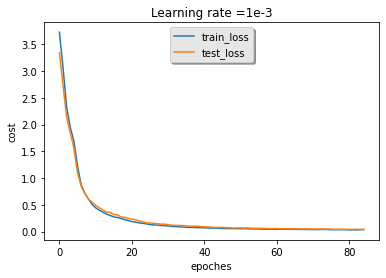

In [24]:
costs_tr = np.squeeze(cost_train)
costs_ts = np.squeeze(cost_validation)
# simi = np.squeeze(similarity_score)
plt.plot(costs_tr, label= 'train_loss')
plt.plot(costs_ts, label= 'test_loss')
# plt.plot(simi, label= 'similarity')
plt.ylabel('cost')
plt.xlabel('epoches')
plt.title("Learning rate =1e-3")
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

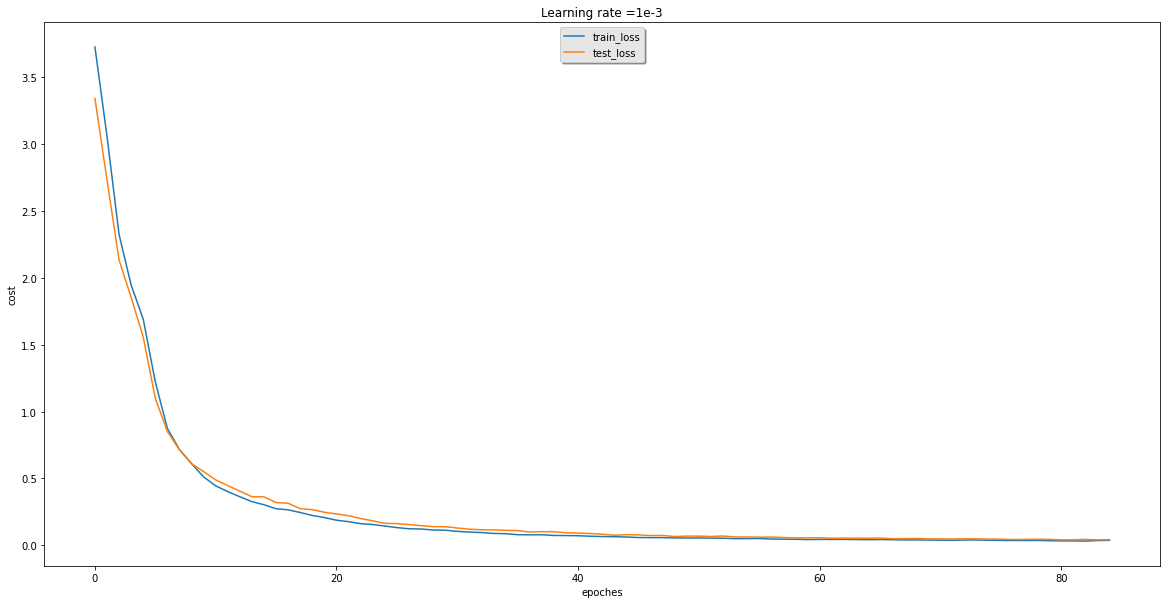

In [25]:
plt.figure(figsize=(20,10))
plt.plot(costs_tr, label= 'train_loss')
plt.plot(costs_ts, label= 'test_loss')
# plt.plot(simi, label= 'similarity')
plt.ylabel('cost')
plt.xlabel('epoches')
plt.title("Learning rate =1e-3")
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

In [26]:
# sm1 = np.squeeze(s1)
# sm2 = np.squeeze(s2)
# sm3 = np.squeeze(s3)
# sm4 = np.squeeze(s4)
# plt.plot(sm1, label= 'similarity1')
# plt.plot(sm2, label= 'similarity2')
# plt.plot(sm3, label= 'similarity3')
# plt.plot(sm4, label= 'similarity4')
# plt.ylabel('simlarity_value')
# plt.xlabel('epoches')
# plt.title("Learning rate =1e-3")
# legend2 = plt.legend(loc='upper center', shadow=True)
# frame = legend2.get_frame()
# frame.set_facecolor('0.90')
# plt.show()

In [27]:
# torch.save(model.state_dict(), "./model_v1")
# print("Saved PyTorch Model State to model.pth")